本节课我们要进入最后一点章节了，也就是BERT模型

BERT其实引领了整个NLP的迁移学习，其实也就是我们前面说的预训练模型，我们不会对预训练模型进行更新，用它来进行特征的抽取、学习
* 在深度学习之前，我们使用word2vec模型或者一些语言模型来做预训练这个事情，这些模型都只能抽取比较底层的特征，往往在这些之上还需要比较复杂的模型去进行训练
* 另一方面，如word2vec这种模型会忽略时序信息，而语言模型只能看到序列一个方向的信息，这并不全面
* BERT的动机就是，在NLP或者序列任务里面，做到和CNN那些预训练模型一样的效果，我只要改最后一层就可以了
* BERT的全称非常fancy，实际上BERT的架构就是一个transformer，并且只有encoder，没有decoder（因为BERT想要做预训练）

BERT除了上面说的去掉decoder这个创新以外，还在输入以及loss上面有一些创新：
* 还记得我们前面讲过的seq2seq或者是RNN，我们本质上其实都是有两个句子对应的关系，这其实也就是训练的时候encoder和decoder分别的输入
* 但是BERT把decoder删掉了，那我怎么做句子的对应呢？
* BERT的做法就是，我直接把encoder的输入搞成一个句子对，我两个句子一起放进去（就是简单的合并起来，中间加分隔符）
* 然后BERT也把前面我们提到的位置编码改成了可学习的版本（这就是弄了个nn.Parameters）
* 不过实际的训练过程中，我们还是希望算法能够知道我们合并起来的句子哪个地方是哪句，所以BERT弄了一个segment embedding层，这个层会给同一句子同样的权重，也就是两个句子的话就是两种权重，一个一种
* 另一点是，还记得我们前面说transformer的时候说，encoder是能够一直看到所有信息的，decoder我们会用mask屏蔽掉后面的信息，从而去做推理
* 但是BERT面临一个问题就是，BERT并没有decoder，BERT想要做预训练模型肯定是不能一直能看到全部序列信息的，这样训练出来的完全没有意义
* BERT的方法同样是对输入进行mask操作
* BERT的做法其实就是，按照一定概率（比如15%），把输入句子的一些词给mask了，然后训练
* 其实这样BERT就变成了一个完形填空的问题了
* BERT的具体策略是，用15%概率去采样token
    * 然后对于采样到的样本我有80%的概率给mask掉，这样就是个完形填空问题
    * 10概率我随机换成别的词
    * 10概率我压根不做任何处理

上面这种策略作者也在论文里面提到了为啥要这样做：
* 作者在论文中谈到了采取上面的mask策略的好处。大致是说采用上面的策略后，Transformer encoder就不知道会让其预测哪个单词，或者说不知道哪个单词会被随机单词给替换掉，那么它就不得不保持每个输入token的一个上下文的表征分布(a distributional contextual representation)。也就是说如果模型学习到了要预测的单词是什么，那么就会丢失对上下文信息的学习，而如果模型训练过程中无法学习到哪个单词会被预测，那么就必须通过学习上下文的信息来判断出需要预测的单词，这样的模型才具有对句子的特征表示能力。另外，由于随机替换相对句子中所有tokens的发生概率只有1.5%(即15%的10%)，所以并不会影响到模型的语言理解能力

上面那种mask的策略是BERT的其中一种训练任务（BERT这个模型就是为了fine tuning来设计的）
* 对于BERT来说还有另一种任务就是，判断句子是否相邻
* 在训练样本中，我随机采样句子，50%的样本我把两个相邻的句子放在一起，50%我把两个随机不相邻的句子放在一起
* 这是BERT中的另一种训练任务

其实可以发现，对于BERT来说，由于它是针对微调来专门设计的模型，所以BERT的训练任务也是非常具有针对性的
* mask的训练策略就是，我要针对样本中的每一个token，我都想学习到他的上下文信息以及序列信息（这也就是mask所起到的作用）
* 而第二种训练任务句子相邻的任务中，其实想要学习的是每个句子的上下文信息
* 其实前面CNN里面的ResNet这种模型也是有设计好的预训练任务的（不过CNN里面就比较简单，就是分类）
* 设计预训练任务的目的就是，能够预训练出更加具有鲁棒性的参数

通过设计这两种训练任务，BERT成功的覆盖了NLP领域里面对一个微调模型的需求（因为NLP的核心需求其实就是上面这两点）

接下来我们来看一下，BERT预训练的相关代码


In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
#@save
# 这里看代码会发现非常简单直接，把你的两个输入拼起来
# 并且加上segments embedding
# 这都是上面讲过的内容
def get_tokens_and_segments(tokens_a, tokens_b=None):
    """获取输入序列的词元及其片段索引"""
    tokens = ['<cls>'] + tokens_a + ['<sep>']
    # 0和1分别标记片段A和B
    segments = [0] * (len(tokens_a) + 2)
    if tokens_b is not None:
        tokens += tokens_b + ['<sep>']
        segments += [1] * (len(tokens_b) + 1)
    return tokens, segments

In [3]:
#@save
# 然后这里就是BERT的encoder了
# 其实和前面的transformer是非常非常相似的
class BERTEncoder(nn.Module):
    """BERT编码器"""
    def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, num_heads, num_layers, dropout,
                 max_len=1000, key_size=768, query_size=768, value_size=768,
                 **kwargs):
        super(BERTEncoder, self).__init__(**kwargs)
        self.token_embedding = nn.Embedding(vocab_size, num_hiddens)
        self.segment_embedding = nn.Embedding(2, num_hiddens)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module(f"{i}", d2l.EncoderBlock(
                key_size, query_size, value_size, num_hiddens, norm_shape,
                ffn_num_input, ffn_num_hiddens, num_heads, dropout, True))
        # 在BERT中，位置嵌入是可学习的，因此我们创建一个足够长的位置嵌入参数
        # 这里也是和前面transformer不一样的地方
        # 其实也非常简单，就是随机初始化一下
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len,
                                                      num_hiddens))

    def forward(self, tokens, segments, valid_lens):
        # 在以下代码段中，X的形状保持不变：（批量大小，最大序列长度，num_hiddens）
        X = self.token_embedding(tokens) + self.segment_embedding(segments)
        X = X + self.pos_embedding.data[:, :X.shape[1], :]
        for blk in self.blks:
            X = blk(X, valid_lens)
        return X

In [4]:
vocab_size, num_hiddens, ffn_num_hiddens, num_heads = 10000, 768, 1024, 4
norm_shape, ffn_num_input, num_layers, dropout = [768], 768, 2, 0.2
encoder = BERTEncoder(vocab_size, num_hiddens, norm_shape, ffn_num_input,
                      ffn_num_hiddens, num_heads, num_layers, dropout)

tokens = torch.randint(0, vocab_size, (2, 8))
segments = torch.tensor([[0, 0, 0, 0, 1, 1, 1, 1], [0, 0, 0, 1, 1, 1, 1, 1]])
encoded_X = encoder(tokens, segments, None)
encoded_X.shape

# 其实上面可以发现，和transformer encoder的输出是非常类似的

torch.Size([2, 8, 768])

* 我们前面提到了，BERT的目标是做一个预训练模型，然后让你来对他进行微调或者是直接迁移学习
* 那其实我们已经定义好了BERT的本体了，BERT就是一个针对输入进行了特殊处理的transformer encoder
* 回想前面CNN那里的预训练模型，我们想要弄预训练模型的本质是，用大量数据去堆出一个具有较好鲁棒性的预训练参数
* 那想要训练获得参数，我们需要训练任务（其实也就是训练的loss）
* 那在CV问题里面，我们的loss其实就比较简单，像ResNet的预训练模型损失不就是分类损失吗，或者目标检测，也是可以定义损失的
* 但是切换到NLP领域中，NLP领域的目标是比较复杂的，像语言模型、机器翻译、句子特征提取、问答模型等等
* BERT接下来要做的就是，它想设计一个训练任务（也就是loss），让BERT通过此loss训练出来的那些参数，能够适用于NLP领域里面的一个通用问题
* 我认为这是理解BERT代码的一个重要角度

In [5]:
#@save
# 这里就是我们在最上面讲解中提到的，利用mask来训练的策略
# 其实可以发现代码还是相对简单的
# 整个预测的结构就是一个MLP
# 我们这里干的事情就是，每次扔一个句子进去，然后告诉它哪些地方被我mask了
# 然后这里的mlp再用前面BERT抽出来的信息去预测这些mask了的地方
class MaskLM(nn.Module):
    """BERT的掩蔽语言模型任务"""
    def __init__(self, vocab_size, num_hiddens, num_inputs=768, **kwargs):
        super(MaskLM, self).__init__(**kwargs)
        self.mlp = nn.Sequential(nn.Linear(num_inputs, num_hiddens),
                                 nn.ReLU(),
                                 nn.LayerNorm(num_hiddens),
                                 nn.Linear(num_hiddens, vocab_size))

    def forward(self, X, pred_positions):
        num_pred_positions = pred_positions.shape[1]
        pred_positions = pred_positions.reshape(-1)
        batch_size = X.shape[0]
        batch_idx = torch.arange(0, batch_size)
        # 假设batch_size=2，num_pred_positions=3
        # 那么batch_idx是np.array（[0,0,0,1,1,1]）
        batch_idx = torch.repeat_interleave(batch_idx, num_pred_positions)
        masked_X = X[batch_idx, pred_positions]
        masked_X = masked_X.reshape((batch_size, num_pred_positions, -1))
        mlm_Y_hat = self.mlp(masked_X)
        return mlm_Y_hat

In [6]:
mlm = MaskLM(vocab_size, num_hiddens)
mlm_positions = torch.tensor([[1, 5, 2], [6, 1, 5]])
mlm_Y_hat = mlm(encoded_X, mlm_positions)
mlm_Y_hat.shape

torch.Size([2, 3, 10000])

In [7]:
mlm_Y = torch.tensor([[7, 8, 9], [10, 20, 30]])
loss = nn.CrossEntropyLoss(reduction='none')
mlm_l = loss(mlm_Y_hat.reshape((-1, vocab_size)), mlm_Y.reshape(-1))
mlm_l.shape
# 和上面我们说的一样，最终是一个分类问题

torch.Size([6])

In [8]:
#@save
# 接下来这个下一句预测就更简单了，就直接是个线性回归
# 甚至是感知机
class NextSentencePred(nn.Module):
    """BERT的下一句预测任务"""
    def __init__(self, num_inputs, **kwargs):
        super(NextSentencePred, self).__init__(**kwargs)
        self.output = nn.Linear(num_inputs, 2)

    def forward(self, X):
        # X的形状：(batchsize,num_hiddens)
        return self.output(X)

In [9]:
encoded_X = torch.flatten(encoded_X, start_dim=1)
# NSP的输入形状:(batchsize，num_hiddens)
nsp = NextSentencePred(encoded_X.shape[-1])
nsp_Y_hat = nsp(encoded_X)
nsp_Y_hat.shape

torch.Size([2, 2])

In [10]:
nsp_y = torch.tensor([0, 1])
nsp_l = loss(nsp_Y_hat, nsp_y)
nsp_l.shape

torch.Size([2])

接下来，我们就可以来实现一个完整的BERT模型了，实际上也就是上面的encoder主体（抽特征）加上两种预测任务（神似MLP出结果）

In [11]:
#@save
class BERTModel(nn.Module):
    """BERT模型"""
    def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, num_heads, num_layers, dropout,
                 max_len=1000, key_size=768, query_size=768, value_size=768,
                 hid_in_features=768, mlm_in_features=768,
                 nsp_in_features=768):
        super(BERTModel, self).__init__()
        self.encoder = BERTEncoder(vocab_size, num_hiddens, norm_shape,
                    ffn_num_input, ffn_num_hiddens, num_heads, num_layers,
                    dropout, max_len=max_len, key_size=key_size,
                    query_size=query_size, value_size=value_size)
        self.hidden = nn.Sequential(nn.Linear(hid_in_features, num_hiddens),
                                    nn.Tanh())
        self.mlm = MaskLM(vocab_size, num_hiddens, mlm_in_features)
        self.nsp = NextSentencePred(nsp_in_features)

    def forward(self, tokens, segments, valid_lens=None,
                pred_positions=None):
        encoded_X = self.encoder(tokens, segments, valid_lens)
        if pred_positions is not None:
            mlm_Y_hat = self.mlm(encoded_X, pred_positions)
        else:
            mlm_Y_hat = None
        # 用于下一句预测的多层感知机分类器的隐藏层，0是“<cls>”标记的索引
        nsp_Y_hat = self.nsp(self.hidden(encoded_X[:, 0, :]))
        # 可以发现，我们最终返回的是三个结果
        # encoded_X，BERT主体抽出来的特征
        # mlm_Y_hat，mask的预测结果
        # nsp_Y_hat，下一句的预测结果
        return encoded_X, mlm_Y_hat, nsp_Y_hat
    
# 最终BERT是啥呢？
# 一个encoder主体把特征拿出来，其实也就是前面CNN预训练里面那些训练好的模型（比如ResNet18）
# 两个小的MLP分别做不同的预测，mask和下一句，和前面CNN同样的道理，CNN里面是一个MLP做分类输出，我们这里弄了两个而已

上面我们就实现了一个完整的BERT模型，可以发现搞清楚逻辑之后，BERT的架构还是非常清晰好理解的

下面我们就来看看，怎么把网页上爬下来的数据转化成BERT训练所需要的数据（BERT用的wikipedia的数据）

In [12]:
import os
import random
import torch
from d2l import torch as d2l

In [13]:
#@save
d2l.DATA_HUB['wikitext-2'] = (
    'https://s3.amazonaws.com/research.metamind.io/wikitext/'
    'wikitext-2-v1.zip', '3c914d17d80b1459be871a5039ac23e752a53cbe')

#@save
# 这里可以发现，用了下划线的这种方式表示是内部函数
def _read_wiki(data_dir):
    file_name = os.path.join(data_dir, 'wiki.train.tokens')
    with open(file_name, 'r') as f:
        lines = f.readlines()
    # 大写字母转换为小写字母
    paragraphs = [line.strip().lower().split(' . ')
                  for line in lines if len(line.split(' . ')) >= 2]
    random.shuffle(paragraphs)
    return paragraphs

In [14]:
#@save
# 预测下一句的数据实现
def _get_next_sentence(sentence, next_sentence, paragraphs):
    if random.random() < 0.5:
        is_next = True
    else:
        # paragraphs是三重列表的嵌套
        next_sentence = random.choice(random.choice(paragraphs))
        is_next = False
    return sentence, next_sentence, is_next

In [15]:
#@save
# 用来调用上面的函数
def _get_nsp_data_from_paragraph(paragraph, paragraphs, vocab, max_len):
    nsp_data_from_paragraph = []
    for i in range(len(paragraph) - 1):
        tokens_a, tokens_b, is_next = _get_next_sentence(
            paragraph[i], paragraph[i + 1], paragraphs)
        # 考虑1个'<cls>'词元和2个'<sep>'词元
        if len(tokens_a) + len(tokens_b) + 3 > max_len:
            continue
        tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
        nsp_data_from_paragraph.append((tokens, segments, is_next))
    return nsp_data_from_paragraph

In [16]:
# 接下来就是另一个训练任务，mask的数据实现
#@save
def _replace_mlm_tokens(tokens, candidate_pred_positions, num_mlm_preds,
                        vocab):
    # 为遮蔽语言模型的输入创建新的词元副本，其中输入可能包含替换的“<mask>”或随机词元
    mlm_input_tokens = [token for token in tokens]
    pred_positions_and_labels = []
    # 打乱后用于在遮蔽语言模型任务中获取15%的随机词元进行预测
    random.shuffle(candidate_pred_positions)
    for mlm_pred_position in candidate_pred_positions:
        if len(pred_positions_and_labels) >= num_mlm_preds:
            break
        masked_token = None
        # 80%的时间：将词替换为“<mask>”词元
        if random.random() < 0.8:
            masked_token = '<mask>'
        else:
            # 10%的时间：保持词不变
            if random.random() < 0.5:
                masked_token = tokens[mlm_pred_position]
            # 10%的时间：用随机词替换该词
            else:
                masked_token = random.choice(vocab.idx_to_token)
        mlm_input_tokens[mlm_pred_position] = masked_token
        pred_positions_and_labels.append(
            (mlm_pred_position, tokens[mlm_pred_position]))
    return mlm_input_tokens, pred_positions_and_labels

In [17]:
#@save
def _get_mlm_data_from_tokens(tokens, vocab):
    candidate_pred_positions = []
    # tokens是一个字符串列表
    for i, token in enumerate(tokens):
        # 在遮蔽语言模型任务中不会预测特殊词元
        if token in ['<cls>', '<sep>']:
            continue
        candidate_pred_positions.append(i)
    # 遮蔽语言模型任务中预测15%的随机词元
    num_mlm_preds = max(1, round(len(tokens) * 0.15))
    mlm_input_tokens, pred_positions_and_labels = _replace_mlm_tokens(
        tokens, candidate_pred_positions, num_mlm_preds, vocab)
    pred_positions_and_labels = sorted(pred_positions_and_labels,
                                       key=lambda x: x[0])
    pred_positions = [v[0] for v in pred_positions_and_labels]
    mlm_pred_labels = [v[1] for v in pred_positions_and_labels]
    return vocab[mlm_input_tokens], pred_positions, vocab[mlm_pred_labels]

In [18]:
#@save
# 这里干的事情其实就是和前面序列模型里面一模一样的
# 如果我们的输入不满足我们的要求长度，我们就加pad上去补上
def _pad_bert_inputs(examples, max_len, vocab):
    max_num_mlm_preds = round(max_len * 0.15)
    all_token_ids, all_segments, valid_lens,  = [], [], []
    all_pred_positions, all_mlm_weights, all_mlm_labels = [], [], []
    nsp_labels = []
    for (token_ids, pred_positions, mlm_pred_label_ids, segments,
         is_next) in examples:
        all_token_ids.append(torch.tensor(token_ids + [vocab['<pad>']] * (
            max_len - len(token_ids)), dtype=torch.long))
        all_segments.append(torch.tensor(segments + [0] * (
            max_len - len(segments)), dtype=torch.long))
        # valid_lens不包括'<pad>'的计数
        valid_lens.append(torch.tensor(len(token_ids), dtype=torch.float32))
        all_pred_positions.append(torch.tensor(pred_positions + [0] * (
            max_num_mlm_preds - len(pred_positions)), dtype=torch.long))
        # 填充词元的预测将通过乘以0权重在损失中过滤掉
        all_mlm_weights.append(
            torch.tensor([1.0] * len(mlm_pred_label_ids) + [0.0] * (
                max_num_mlm_preds - len(pred_positions)),
                dtype=torch.float32))
        all_mlm_labels.append(torch.tensor(mlm_pred_label_ids + [0] * (
            max_num_mlm_preds - len(mlm_pred_label_ids)), dtype=torch.long))
        nsp_labels.append(torch.tensor(is_next, dtype=torch.long))
    return (all_token_ids, all_segments, valid_lens, all_pred_positions,
            all_mlm_weights, all_mlm_labels, nsp_labels)

In [19]:
#@save
# 最后还是一样的，我们继承一个torch的dataset类
class _WikiTextDataset(torch.utils.data.Dataset):
    def __init__(self, paragraphs, max_len):
        # 输入paragraphs[i]是代表段落的句子字符串列表；
        # 而输出paragraphs[i]是代表段落的句子列表，其中每个句子都是词元列表
        paragraphs = [d2l.tokenize(
            paragraph, token='word') for paragraph in paragraphs]
        sentences = [sentence for paragraph in paragraphs
                     for sentence in paragraph]
        self.vocab = d2l.Vocab(sentences, min_freq=5, reserved_tokens=[
            '<pad>', '<mask>', '<cls>', '<sep>'])
        # 获取下一句子预测任务的数据
        examples = []
        for paragraph in paragraphs:
            examples.extend(_get_nsp_data_from_paragraph(
                paragraph, paragraphs, self.vocab, max_len))
        # 获取遮蔽语言模型任务的数据
        examples = [(_get_mlm_data_from_tokens(tokens, self.vocab)
                      + (segments, is_next))
                     for tokens, segments, is_next in examples]
        # 填充输入
        (self.all_token_ids, self.all_segments, self.valid_lens,
         self.all_pred_positions, self.all_mlm_weights,
         self.all_mlm_labels, self.nsp_labels) = _pad_bert_inputs(
            examples, max_len, self.vocab)

    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx], self.all_pred_positions[idx],
                self.all_mlm_weights[idx], self.all_mlm_labels[idx],
                self.nsp_labels[idx])

    def __len__(self):
        return len(self.all_token_ids)

In [20]:
#@save
# 然后我们用一个load函数读取
# 因为我们是预训练模型，所以我们都没有test data
def load_data_wiki(batch_size, max_len):
    """加载WikiText-2数据集"""
    num_workers = d2l.get_dataloader_workers()
    data_dir = d2l.download_extract('wikitext-2', 'wikitext-2')
    paragraphs = _read_wiki(data_dir)
    train_set = _WikiTextDataset(paragraphs, max_len)
    train_iter = torch.utils.data.DataLoader(train_set, batch_size,
                                        shuffle=True, num_workers=num_workers)
    return train_iter, train_set.vocab

In [21]:
batch_size, max_len = 512, 64
train_iter, vocab = load_data_wiki(batch_size, max_len)

for (tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X,
     mlm_Y, nsp_y) in train_iter:
    print(tokens_X.shape, segments_X.shape, valid_lens_x.shape,
          pred_positions_X.shape, mlm_weights_X.shape, mlm_Y.shape,
          nsp_y.shape)
    break

# 可以发现，我们一个batch里面有tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X, mlm_Y, nsp_y
# 这一堆东西
# 所以NLP领域的数据集其实是比CV里面要复杂很多很多很多的
# CV里面一个图像其实就可以认为是一个矩阵了，但是自然语言是不能这样认为的

torch.Size([512, 64]) torch.Size([512, 64]) torch.Size([512]) torch.Size([512, 10]) torch.Size([512, 10]) torch.Size([512, 10]) torch.Size([512])


In [22]:
len(vocab)
# 我们的token数量也是很大的（这还是过滤了的情况）

20256

In [23]:
list(vocab.token_to_idx.items())[:10]
# 可以发现一个有意思的
# 对于wikipedia的数据来说
# the of and in这几个词是出现频率最高的

[('<unk>', 0),
 ('<pad>', 1),
 ('<mask>', 2),
 ('<cls>', 3),
 ('<sep>', 4),
 ('the', 5),
 (',', 6),
 ('of', 7),
 ('and', 8),
 ('in', 9)]

做完了上面所有事情，我们接下来就可以来预训练BERT模型了

In [24]:
import torch
from torch import nn
from d2l import torch as d2l

In [25]:
batch_size, max_len = 512, 64
train_iter, vocab = d2l.load_data_wiki(batch_size, max_len)

In [26]:
net = d2l.BERTModel(len(vocab), num_hiddens=128, norm_shape=[128],
                    ffn_num_input=128, ffn_num_hiddens=256, num_heads=2,
                    num_layers=2, dropout=0.2, key_size=128, query_size=128,
                    value_size=128, hid_in_features=128, mlm_in_features=128,
                    nsp_in_features=128)
# BERT是一个比较大的模型，所以我们这里使用所有GPU去训练他
devices = d2l.try_all_gpus()
loss = nn.CrossEntropyLoss()

In [27]:
#@save
# 这里我们是定义了一个辅助函数，其实也就是把两种训练任务的loss加起来
# l = mlm_l + nsp_l
def _get_batch_loss_bert(net, loss, vocab_size, tokens_X,
                         segments_X, valid_lens_x,
                         pred_positions_X, mlm_weights_X,
                         mlm_Y, nsp_y):
    # 前向传播
    _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, segments_X,
                                  valid_lens_x.reshape(-1),
                                  pred_positions_X)
    # 计算遮蔽语言模型损失
    mlm_l = loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) *\
    mlm_weights_X.reshape(-1, 1)
    mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8)
    # 计算下一句子预测任务的损失
    nsp_l = loss(nsp_Y_hat, nsp_y)
    l = mlm_l + nsp_l
    return mlm_l, nsp_l, l

In [28]:
# 接下来就是老样子了，写一个训练函数
def train_bert(train_iter, net, loss, vocab_size, devices, num_steps):
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    trainer = torch.optim.Adam(net.parameters(), lr=0.01)
    step, timer = 0, d2l.Timer()
    animator = d2l.Animator(xlabel='step', ylabel='loss',
                            xlim=[1, num_steps], legend=['mlm', 'nsp'])
    # 遮蔽语言模型损失的和，下一句预测任务损失的和，句子对的数量，计数
    metric = d2l.Accumulator(4)
    num_steps_reached = False
    while step < num_steps and not num_steps_reached:
        for tokens_X, segments_X, valid_lens_x, pred_positions_X,\
            mlm_weights_X, mlm_Y, nsp_y in train_iter:
            tokens_X = tokens_X.to(devices[0])
            segments_X = segments_X.to(devices[0])
            valid_lens_x = valid_lens_x.to(devices[0])
            pred_positions_X = pred_positions_X.to(devices[0])
            mlm_weights_X = mlm_weights_X.to(devices[0])
            mlm_Y, nsp_y = mlm_Y.to(devices[0]), nsp_y.to(devices[0])
            trainer.zero_grad()
            timer.start()
            mlm_l, nsp_l, l = _get_batch_loss_bert(
                net, loss, vocab_size, tokens_X, segments_X, valid_lens_x,
                pred_positions_X, mlm_weights_X, mlm_Y, nsp_y)
            l.backward()
            trainer.step()
            metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)
            timer.stop()
            animator.add(step + 1,
                         (metric[0] / metric[3], metric[1] / metric[3]))
            step += 1
            if step == num_steps:
                num_steps_reached = True
                break

    print(f'MLM loss {metric[0] / metric[3]:.3f}, '
          f'NSP loss {metric[1] / metric[3]:.3f}')
    print(f'{metric[2] / timer.sum():.1f} sentence pairs/sec on '
          f'{str(devices)}')

MLM loss 5.605, NSP loss 0.759
1200.4 sentence pairs/sec on [device(type='cuda', index=0), device(type='cuda', index=1), device(type='cuda', index=2), device(type='cuda', index=3), device(type='cuda', index=4), device(type='cuda', index=5), device(type='cuda', index=6), device(type='cuda', index=7)]


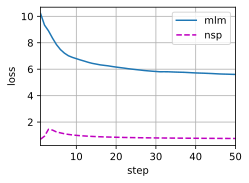

In [29]:
# 然后开炉炼丹
train_bert(train_iter, net, loss, len(vocab), devices, 50) # 这里只训练50
# 这里的step其实是batch的意思，50 step就是50 batch
# 为啥不用epoch，李沐老师解释是现在数据集可能比较大，一次训练不会用完整数据，所以用batch更好量化一点
# 李沐老师说真正训练出来能用的BERT需要差不多几天，100w个batch

那上面我们训练好了BERT(X)，我们接下来就可以用BERT来抽取特征了，还记得吗，BERT本质上是一个encoder

In [30]:
def get_bert_encoding(net, tokens_a, tokens_b=None):
    tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
    token_ids = torch.tensor(vocab[tokens], device=devices[0]).unsqueeze(0)
    segments = torch.tensor(segments, device=devices[0]).unsqueeze(0)
    valid_len = torch.tensor(len(tokens), device=devices[0]).unsqueeze(0)
    # 这里其实是一样的，只不过和训练时不同，我们不看loss，我们就看encoder
    encoded_X, _, _ = net(token_ids, segments, valid_len)
    return encoded_X

In [31]:
tokens_a = ['a', 'crane', 'is', 'flying']
encoded_text = get_bert_encoding(net, tokens_a)
# 词元：'<cls>','a','crane','is','flying','<sep>'
encoded_text_cls = encoded_text[:, 0, :]
encoded_text_crane = encoded_text[:, 2, :]
encoded_text.shape, encoded_text_cls.shape, encoded_text_crane[0][:3]

# 这里是一个句子的情况

(torch.Size([1, 6, 128]),
 torch.Size([1, 128]),
 tensor([-0.0367, -0.2028, -1.8901], device='cuda:0', grad_fn=<SliceBackward0>))

In [32]:
tokens_a, tokens_b = ['a', 'crane', 'driver', 'came'], ['he', 'just', 'left']
encoded_pair = get_bert_encoding(net, tokens_a, tokens_b)
# 词元：'<cls>','a','crane','driver','came','<sep>','he','just',
# 'left','<sep>'
encoded_pair_cls = encoded_pair[:, 0, :]
encoded_pair_crane = encoded_pair[:, 2, :]
encoded_pair.shape, encoded_pair_cls.shape, encoded_pair_crane[0][:3]

# 两个句子也是相同的抽特征

(torch.Size([1, 10, 128]),
 torch.Size([1, 128]),
 tensor([ 0.0138, -0.1593, -1.8163], device='cuda:0', grad_fn=<SliceBackward0>))

可以发现，BERT的整体架构在理解之后还是比较清晰的，有几个点是需要注意的
* 预训练的本质是用超大数据去得到参数，而想要得到参数就需要设计合适的训练任务，其实也就是loss
* BERT是用mask来去解决self attention里面不能看到序列信息的问题，在正常的transformer里面，由于存在decoder的mask，所以encoder部分可以直接看到全部序列信息没关系
* 但是BERT本质是特征提取的encoder，所以不能让BERT去总是看到全部信息，而忽略序列信息，所以采用了mask的方法
* 而在mask方法里面，我们会允许mask产生类似“作弊”的效果，这其实是BERT为了fine tuning考虑的
* 因为我们知道fine tuning其实就是一个正常的训练任务，此时BERT作为encoder接受到的肯定是完整的信息，所以也不能让BERT过于关注mask的预测而忽略原本的信息